# Submission Group Assignment Network Science HS22

Participants:

    Alexander Christian Lerch, 17-678-111
    Diego Ricardo Bugmann, 18-472-548
    Szymon Kaczmarski, 21-743-778      

### LIBRARIES & DATASET

In [1]:
#import the packages needed
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp
import networkx.algorithms.community as nxcom
from matplotlib import colors as mcolors
import powerlaw
from scipy.special import factorial
import pandas as pd
from tabulate import tabulate
import time
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
from tqdm import tqdm

In [2]:
# PATH DE
PATH_TWITCH_DE = 'dataset//DE//musae_DE_edges.csv'
# DATASET DE
with open(PATH_TWITCH_DE, 'rb') as twitch:
    next(twitch, '')   # skip a line
    G_TWITCH_DE = nx.read_edgelist(twitch, delimiter=',', create_using=nx.Graph(), nodetype=int, encoding="utf-8")
print(PATH_TWITCH_DE, ' : ', G_TWITCH_DE)
# print("Number of nodes: ", G_TWITCH.number_of_nodes())
# print("Number of edges: ", G_TWITCH_DE.number_of_edges())


# PATH EN
PATH_TWITCH = 'dataset//ENGB//musae_ENGB_edges.csv'
# DATASET EN
with open(PATH_TWITCH, 'rb') as twitch:
    next(twitch, '')   # skip a line
    G_TWITCH = nx.read_edgelist(twitch, delimiter=',', create_using=nx.Graph(), nodetype=int, encoding="utf-8")
print(PATH_TWITCH, ' : ', G_TWITCH)
# print("Number of nodes: ", G_TWITCH.number_of_nodes())
# print("Number of edges: ", G_TWITCH.number_of_edges())

dataset//DE//musae_DE_edges.csv  :  Graph with 9498 nodes and 153138 edges
dataset//ENGB//musae_ENGB_edges.csv  :  Graph with 7126 nodes and 35324 edges


In [4]:
# PATH DE
# PATH_TWITCH_FEATURES = 'dataset//DE//musae_DE_target.csv'
# PATH EN
PATH_TWITCH_FEATURES = 'dataset//ENGB//musae_ENGB_target.csv'

# READ FEATURES INTO DF
df_twitch_features = pd.read_csv(PATH_TWITCH_FEATURES, sep=',', header=0, index_col=0)

# ALGORITHMS

In [14]:
def hindex_for_node(g, n): 
    sorted_neighbor_degrees = sorted((g.degree(v) for v in g.neighbors(n)), reverse=True) 
    h = 0 
    for i in range(1, len(sorted_neighbor_degrees)+1): 
        if sorted_neighbor_degrees[i-1] < i: 
            break 
        h = i 
    return h 

def hindex(g): 
    hindex_list = [] 
    n = g.number_of_nodes()
    for n in g.nodes(): 
        hindex_list.append(hindex_for_node(g, n)) 
    return hindex_list

In [ ]:
# pagerank(G, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None) 
# eigenvector_centrality(G, max_iter=100, tol=1e-06, nstart=None, weight=None) 
# k_shell(G, k=None, core_number=None) – returns the k-shell subgraph 

In [17]:
algorithms_names = ['Degree Centrality', 'K-Shell', 'Betweenness Centrality', 'Voterank', 'Pagerank', 'Closeness Centrality', 'Eigenvector Centrality', 'H-Index']
pbar = tqdm(total=len(algorithms_names))
results = []
st = time.time()
pbar.set_description("Processing %s" % algorithms_names[0])
results.append(nx.degree_centrality(G_TWITCH_DE))
pbar.update(1)
pbar.set_description("Processing %s" % algorithms_names[1])
results.append(nx.k_shell(G_TWITCH_DE))
pbar.update(1)
pbar.set_description("Processing %s" % algorithms_names[2])
results.append(nx.betweenness_centrality(G_TWITCH_DE))
pbar.update(1)
pbar.set_description("Processing %s" % algorithms_names[3])
results.append(nx.voterank(G_TWITCH_DE))
pbar.update(1)
pbar.set_description("Processing %s" % algorithms_names[4])
results.append(nx.pagerank(G_TWITCH, max_iter=100, tol=1e-06))
pbar.update(1)
pbar.set_description("Processing %s" % algorithms_names[5])
results.append(nx.closeness_centrality(G_TWITCH_DE))
pbar.update(1)
pbar.set_description("Processing %s" % algorithms_names[6])
results.append(nx.eigenvector_centrality(G_TWITCH_DE))
pbar.update(1)
pbar.set_description("Processing %s" % algorithms_names[7])
results.append(hindex(G_TWITCH_DE))
pbar.update(1)
pbar.close()
print("Minutes elapsed: ", (time.time() - st)/60)

Processing Betweenness Centrality:  25%|██▌       | 2/8 [00:10<00:31,  5.20s/it]


In [87]:
# method to calculate the infected scale
def get_infected_scale(infected, recovered, total):
    return (infected + recovered) / total

# method to plot values
def plot_values(x, y, title):
    plt.plot(x, y)
    plt.ylabel("F(t)")
    plt.xlabel("t")
    plt.title(title)
    plt.show()

# method to get beta
def get_beta(network):
    beta_threshold = get_infection_threshold(network)
    return 1.5 * beta_threshold
    
# method to get the infection threshold
def get_infection_threshold(network):
    degrees = [v for k,v in network.degree()]
    avg_degree = np.mean(degrees)
    avg_sqrd_degrees = np.mean([d**2 for d in degrees])
    bth = avg_degree / (avg_sqrd_degrees - avg_degree)
    return bth

# method to get gamma
def get_gamma(network):
    degrees = [v for k,v in network.degree()]
    avg_degree = np.mean(degrees)
    return 2 / avg_degree

In [91]:
# method to simulate a model
def simulate(network, p, beta=None, gamma=None, num_of_simulations=100, num_of_t=200, show_bar=True):

    # ---------- Model Configuration ----------
    model = ep.SIRModel(network)
    n = network.number_of_nodes()
    
    # Beta and Gamma is chosen basen on explanation in paragraph 3.2
    beta = get_beta(network) if beta == None else beta
    gamma = get_gamma(network) if gamma == None else gamma
    
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta) # INFECTION PROBABILITY
    cfg.add_model_parameter('gamma', gamma) # RECOVERY PROBABILITY
    cfg.add_model_parameter("fraction_infected", p)   # TODO REMOVE

    # -------------------------------------------------------
    # TODO : Selection of initial nodes based on algorithms
    # infected_nodes = []
    # cfg.add_model_initial_configuration("Infected", infected_nodes)
    # -------------------------------------------------------

    model.set_initial_status(cfg)


    # ---------- Simulation ----------
    
    # execute the simulations and save them in a list
    simulations = []
    for i in range(num_of_simulations):
        model.reset() # reset so that each simulation starts from scratch
        simulation = model.iteration_bunch(num_of_t, progress_bar=show_bar)
        simulations.append(simulation)

    x = list(range(num_of_t))
    y = []

    # average out the infected / recovered for each step, calculate the infected_scale and save it to a list
    for i in range(num_of_t):
        infected = np.mean([simulation[i]['node_count'][1] for simulation in simulations]) # get the mean for each step
        recovered = np.mean([simulation[i]['node_count'][2] for simulation in simulations]) # get the mean for each step
        # calculate F(t) and add it to the y-values
        infected_scale_value = get_infected_scale(infected, recovered, n)
        y.append(infected_scale_value)
    
    print("Beta: "+str(beta))
    print("Gamma: "+str(gamma))
    
    return x, y


Beta: 0.025608421113680682
Gamma: 0.20173253312195674


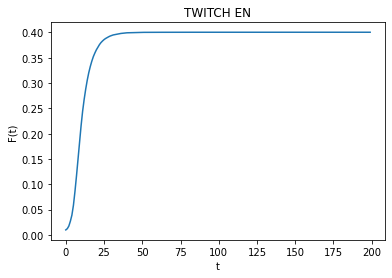

Beta: 0.005900017098483644
Gamma: 0.062022489519257144


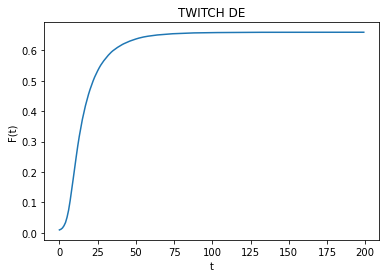

In [92]:
# ---------- Simulate & Plot the values (EN) ----------
x, y = simulate(G_TWITCH, p=0.01, num_of_simulations=10, show_bar=False)
plot_values(x, y, "TWITCH EN")

# ---------- Simulate & Plot the values (DE) ----------
x, y = simulate(G_TWITCH_DE, p=0.01, num_of_simulations=10, show_bar=False)
plot_values(x, y, "TWITCH DE")


<k>: 27.696969696969695
bth = 0.026566678293221718
beta = 1.5 * bth = 0.039850017439832575
gamma = beta / lambda (1.25) = 0.03188001395186606
p = 0.02
Beta: 0.039850017439832575
Gamma: 0.03188001395186606


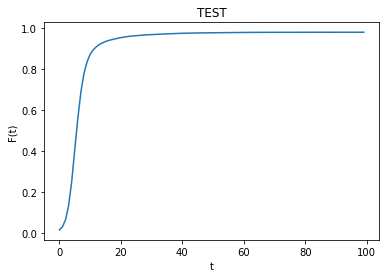

COMPARE PLOT TO FIGURE 2 (PAGE 10) IN PAPER [2]


In [97]:
# -------------------- SECTION DIFFERENT DATASETS --------------------

# !!!!! uncomment the one you want to use and then run !!!!!

# ---------- FACEBOOK ----------
# G = nx.read_gml("dataset/graph_facebook.gml")


# ---------- JAZZ ----------
G = nx.read_gml("dataset/graph_jazz_collab.gml")


# ---------- DOLPHINS ----------
# G = nx.read_gml("dataset/graph_dolphins.gml")



# -------------------- Calculate some numbers in order to get the same parameters as in paper [2] --------------------
n = G.number_of_nodes()
degrees = [v for k,v in G.degree()]
avg_degree = np.mean(degrees)
avg_sqrd_degrees = np.mean([d**2 for d in degrees])

print("<k>: "+str(avg_degree))
bth = get_infection_threshold(G)                          # [2] PAGE 7 (formula for bth) / PAGE 10 table 4 (value for bth)
beta = 1.5 * bth                                          # [2] PAGE 7 (formula for beta)
lamb = 1.25                                               # [2] PAGE 11 figure 2 (ratio infection prob / recovery prob)
p = 0.02                                                  # [2] PAGE 11 figure 2
print("bth = "+str(bth))
print("beta = 1.5 * bth = "+str(beta))
gamma = beta / lamb                                       # [2] PAGE 7 (formula for beta)
print("gamma = beta / lambda (1.25) = "+str(gamma))       # [2] PAGE 11 figure 2: Use ratio of 1.25
print("p = "+str(p))


# ---------- Simulate ----------
x, y = simulate(G, p=p, beta=beta, gamma=gamma, num_of_simulations=100, num_of_t=100, show_bar=False)

# ---------- Plot the values ----------
plot_values(x, y, "TEST")
print("COMPARE PLOT TO FIGURE 2 (PAGE 10) IN PAPER [2]")